In [420]:
from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt

In [380]:
data = loadStooqData('cpiypl.m','1991-01-01')

In [386]:
def ornstein_uhlenbeck_params(series):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/(1/12)
    u = a/k
    resid = res.resid
    sig = np.sqrt(np.mean(resid**2))
    sig = np.round(sig,4)

    return (u,sig,k)


In [513]:
cpi = data['1999-01-01':'2023-12-31'] / 100
display(cpi.describe())
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
u,sig,k = ornstein_uhlenbeck_params(cpi)

count    295.000000
mean       0.036410
std        0.038408
min       -0.016000
25%        0.013000
50%        0.028000
75%        0.044000
max        0.184000
Name: Zamkniecie, dtype: float64

In [ ]:
cpi.describeI\

In [505]:
print(u)
print(sig)
print(k)

0.004973571077902194
0.005
0.058957973158590526


In [506]:
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=u,sigma=sig,theta=k)

In [507]:
length = 180
scenarios = simulator.scenarios(0.044,1,5000,length)

In [508]:
perc = np.percentile(scenarios,[5,25,50,75,95],axis=0)

In [509]:
def fanchart(hist,percentiles):
    x = np.linspace(0,length+1,length+1)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[4], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[3], color='blue', alpha=0.2)
    ax.plot(percentiles[2],color='blue')

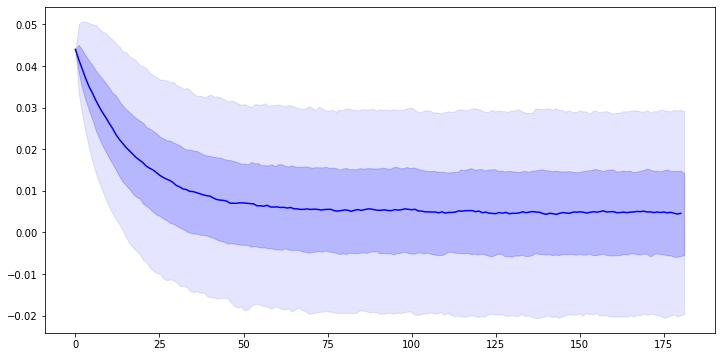

In [514]:
fanchart(cpi,perc)

In [515]:
def percentile_summary(perc):
    perc_dict = {'perc': ['5','25','50','75','95'],
                 '1': perc[:,12],
                 '2': perc[:,24],
                 '3': perc[:,36],
                 '5': perc[:,60],
                 '10': perc[:,120],
                 #'20': perc[:,240],}
    }
    perc_summary = pd.DataFrame(perc_dict)
    return perc_summary
percentile_summary(perc)

,perc,1,2,3,5,10
0,5,0.003178,-0.009702,-0.014110,-0.018055,-0.020037
1,25,0.015027,0.004264,-0.000287,-0.004064,-0.005122
2,50,0.023617,0.014464,0.009578,0.006150,0.005154
3,75,0.032914,0.023778,0.019561,0.016420,0.015281
4,95,0.045440,0.037333,0.032773,0.030786,0.029413
